# Estimate the probability of the first detection of covid-19 for each prefecture. 
2020/02/27 時点での感染者のデータを用いて，指数関数的に増加するフェーズにおいて，<br>
空港での移動を介した県内初感染が起きる確率を推定した．<br>
確率は3,6,9,12日後におけるものを示した．


# model  specification


$ C_{i ,t } $ is # of reported cases at place i at time t.  <br>
$ m_{i,j} $ is # of people moving from place i to place j via airplanes.  <br>
$ p_{i,j} $ is proportion of travelers from place j to i relative to the population at place j. <br>  
$ N_i $ is the number of population at place i. <br>
We assume that cases increase exponentially at same rate for each place. <br>

The equation is given by 
$$
    \Delta C_{ i, t} = C_{ i, t} - C_{i,t-\Delta t}
                    = (e^{r\Delta t }-1)(\sum_{ j} p_{ i, j}C_{ j,t-\Delta t})  ,
$$
where $p_{i,j} = \frac{m_{i,j}}{N_j} $ and $m_{j,j} = N_j $ . <br>
Dividing $\Delta t $ and taking the limit $\Delta t \rightarrow 0$ gives 
$$
    \frac{dC_{i,t} }{dt}   = r\sum_j p_{i,j}C_{j,t-\Delta t}  , 
$$

#  Data
- exponential growth rate : estimated here. 
- 累積報告感染者数 : 2020/01/15の初発例から 2020/02/27 までのデータ．arcgisより. "dt_main/case_summary.xlsx" <br> 
https://jagjapan.maps.arcgis.com/apps/opsdashboard/index.html#/641eba7fef234a47880e1e1dc4de85ce
- $ m_{i,j} $  : 飛行機を用いた移動者数/日．　ANAの航空データより. 
- $ p_{i,j} $  : 1日ごとの県人口に対する飛行機を利用する人数の割合．"dt_main/prop.npy". 
- $ N_i $  : 県別人口. H27年国勢調査より． "dt_main/pref_population.xlsx" 
- 都道府県別感染者数 : 2020/02/27時点でのデータ. arcgisより．"dt_main/case_20200227.xlsx". 　


# 0. setting 

In [9]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context="paper" , style ="whitegrid",rc={"figure.facecolor":"white"})
import statsmodels.api as sm
import japanmap as jm
import matplotlib

import dill
import datetime

# custom modules 
import pathList as pL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. obtain exponential growth rate

Text(0, 0.5, 'log of cumulative # of cases')

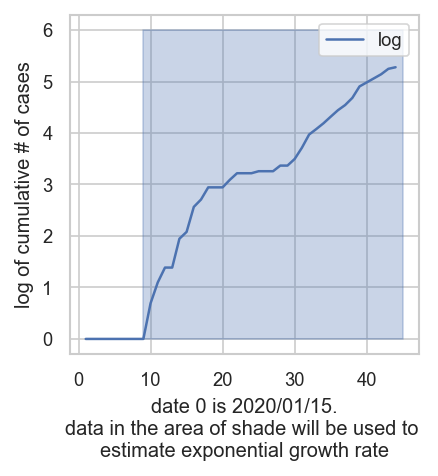

In [5]:
df = pd.read_excel(pL.caseRecord)
df["log"] = np.log(df["case"])

fig = plt.figure(figsize=(3,3),dpi=150)
ax = fig.subplots(1,1)
df.plot(x="date",y="log",ax=ax)
ax.fill_between(x=[9,45],y1=[0,0],y2=[6,6],alpha=0.3,color="b")
plt.xlabel(f"date 0 is 2020/01/15.\ndata in the area of shade will be used to \nestimate exponential growth rate")
plt.ylabel("log of cumulative # of cases")

## fitting results

In [6]:
vals = df.loc[9:,"log"].values
t = [i for i in range(len(vals))]
exog = pd.DataFrame({"t":t,"const":1})
mod = sm.OLS( vals,exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     582.6
Date:                Thu, 27 Feb 2020   Prob (F-statistic):           1.52e-22
Time:                        23:28:18   Log-Likelihood:                -4.8791
No. Observations:                  35   AIC:                             13.76
Df Residuals:                      33   BIC:                             16.87
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.1157      0.005     24.138      0.0

In [7]:
res.params

t        0.115731
const    1.461259
dtype: float64

Text(0.5, 1.0, 'check the fittness.')

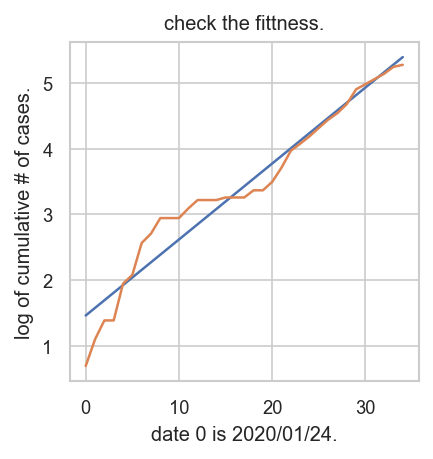

In [10]:
plt.figure(figsize=(3,3),dpi = 150)
plt.plot(t,np.array(t)*res.params["t"]+res.params["const"])
plt.plot(t,vals)
plt.xlabel(f"date 0 is 2020/01/24.")
plt.ylabel("log of cumulative # of cases.")
plt.title("check the fittness.")

# 2. simulation using Gillespie algorithm# gillespie algorithm is 
gillespie algorithm is implemented in the module "simGillespie.py" 

In [4]:
# custom modules
import simGillespie as sG

In [86]:
# defalut values 
p = np.load(pL.dataProp)
r = res.params["t"]
C0 = pd.read_excel(pL.casePrefecture)
C0 = C0["case"].values

In [110]:
# simulation part 
nSim = 100
tCutoff =  20

np.random.seed(100)
rec = sG.multiSim(nSim,r,p,C0,tCutoff,time= False)
path = sG.saveData(rec,pL.recSim)
path
print(f"saved path : {path}\n# of simulations : {nSim}\nSimulations stop after {tCutoff} days")

saved path : ../dt_sim/simResults_20200227_231306.dl
# of simulations : 100
Simulations stop after 20 days


# 3. visualization  of the result

In [134]:
# custom modules 
import visTools as vT

In [96]:
with open(path,"rb") as f:
    d = dill.load(f)
#d.keys()

The probability of new infection via airplanes occuring at each prefecture through time
printed prefectures are areas sill not with reported cases and with some airportt
Areas without any airport are omitted.


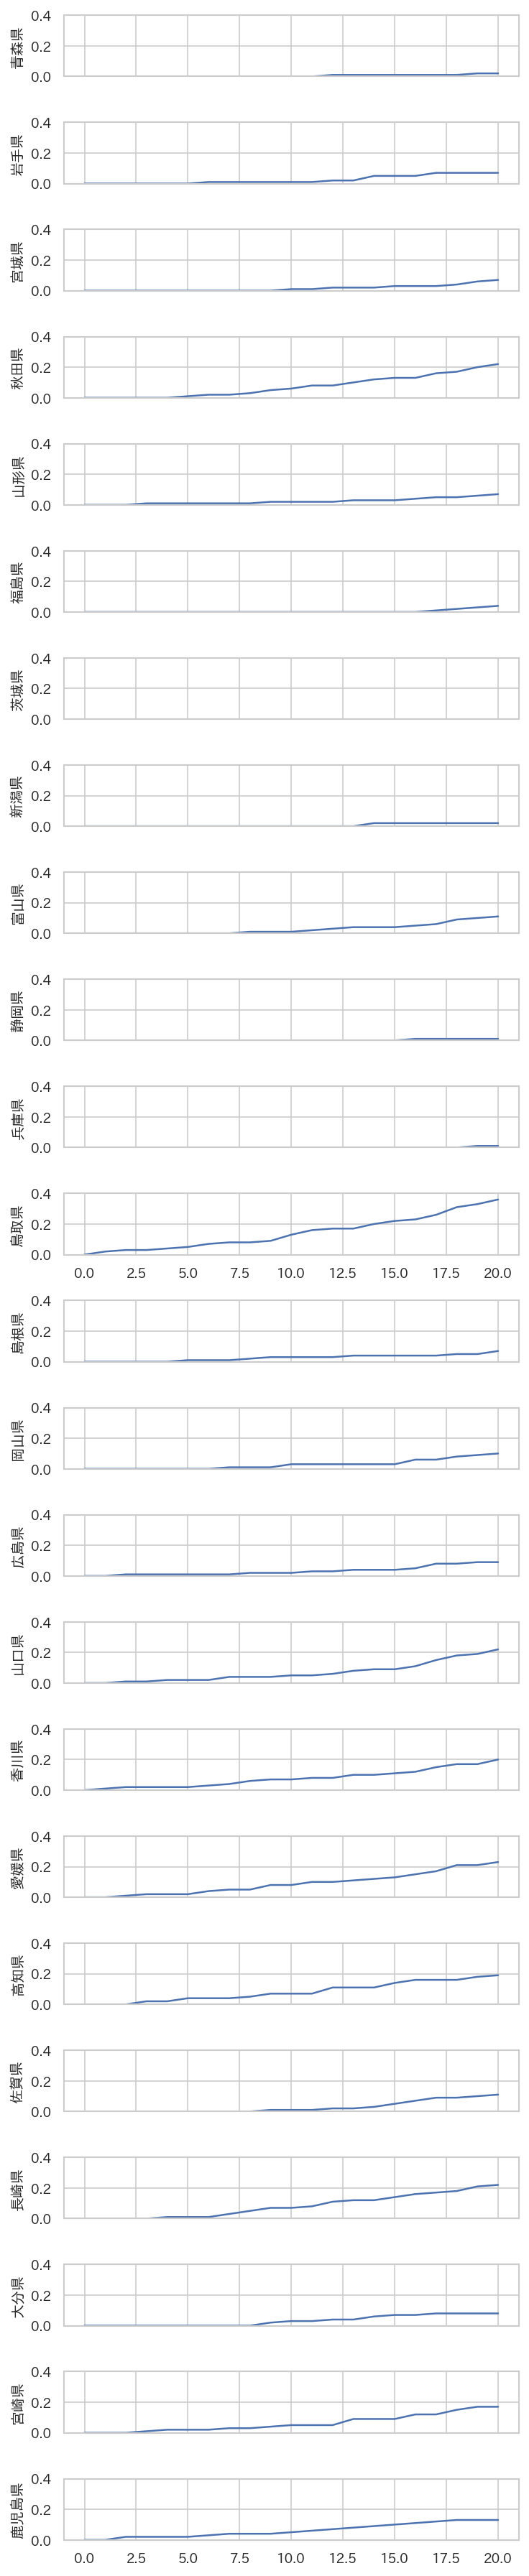

In [139]:
ind0 = vT.getPossibleAreas(C0)
print("The probability of new infection via airplanes occuring at each prefecture through time")
print("printed prefectures are areas sill not with reported cases and with some airportt")
print("Areas without any airport are omitted.")
vT.timeSeriesProb(ind0,d)


the probability of new infection via airplanes occuring.
the start date of the simulations is 2020/02/27 


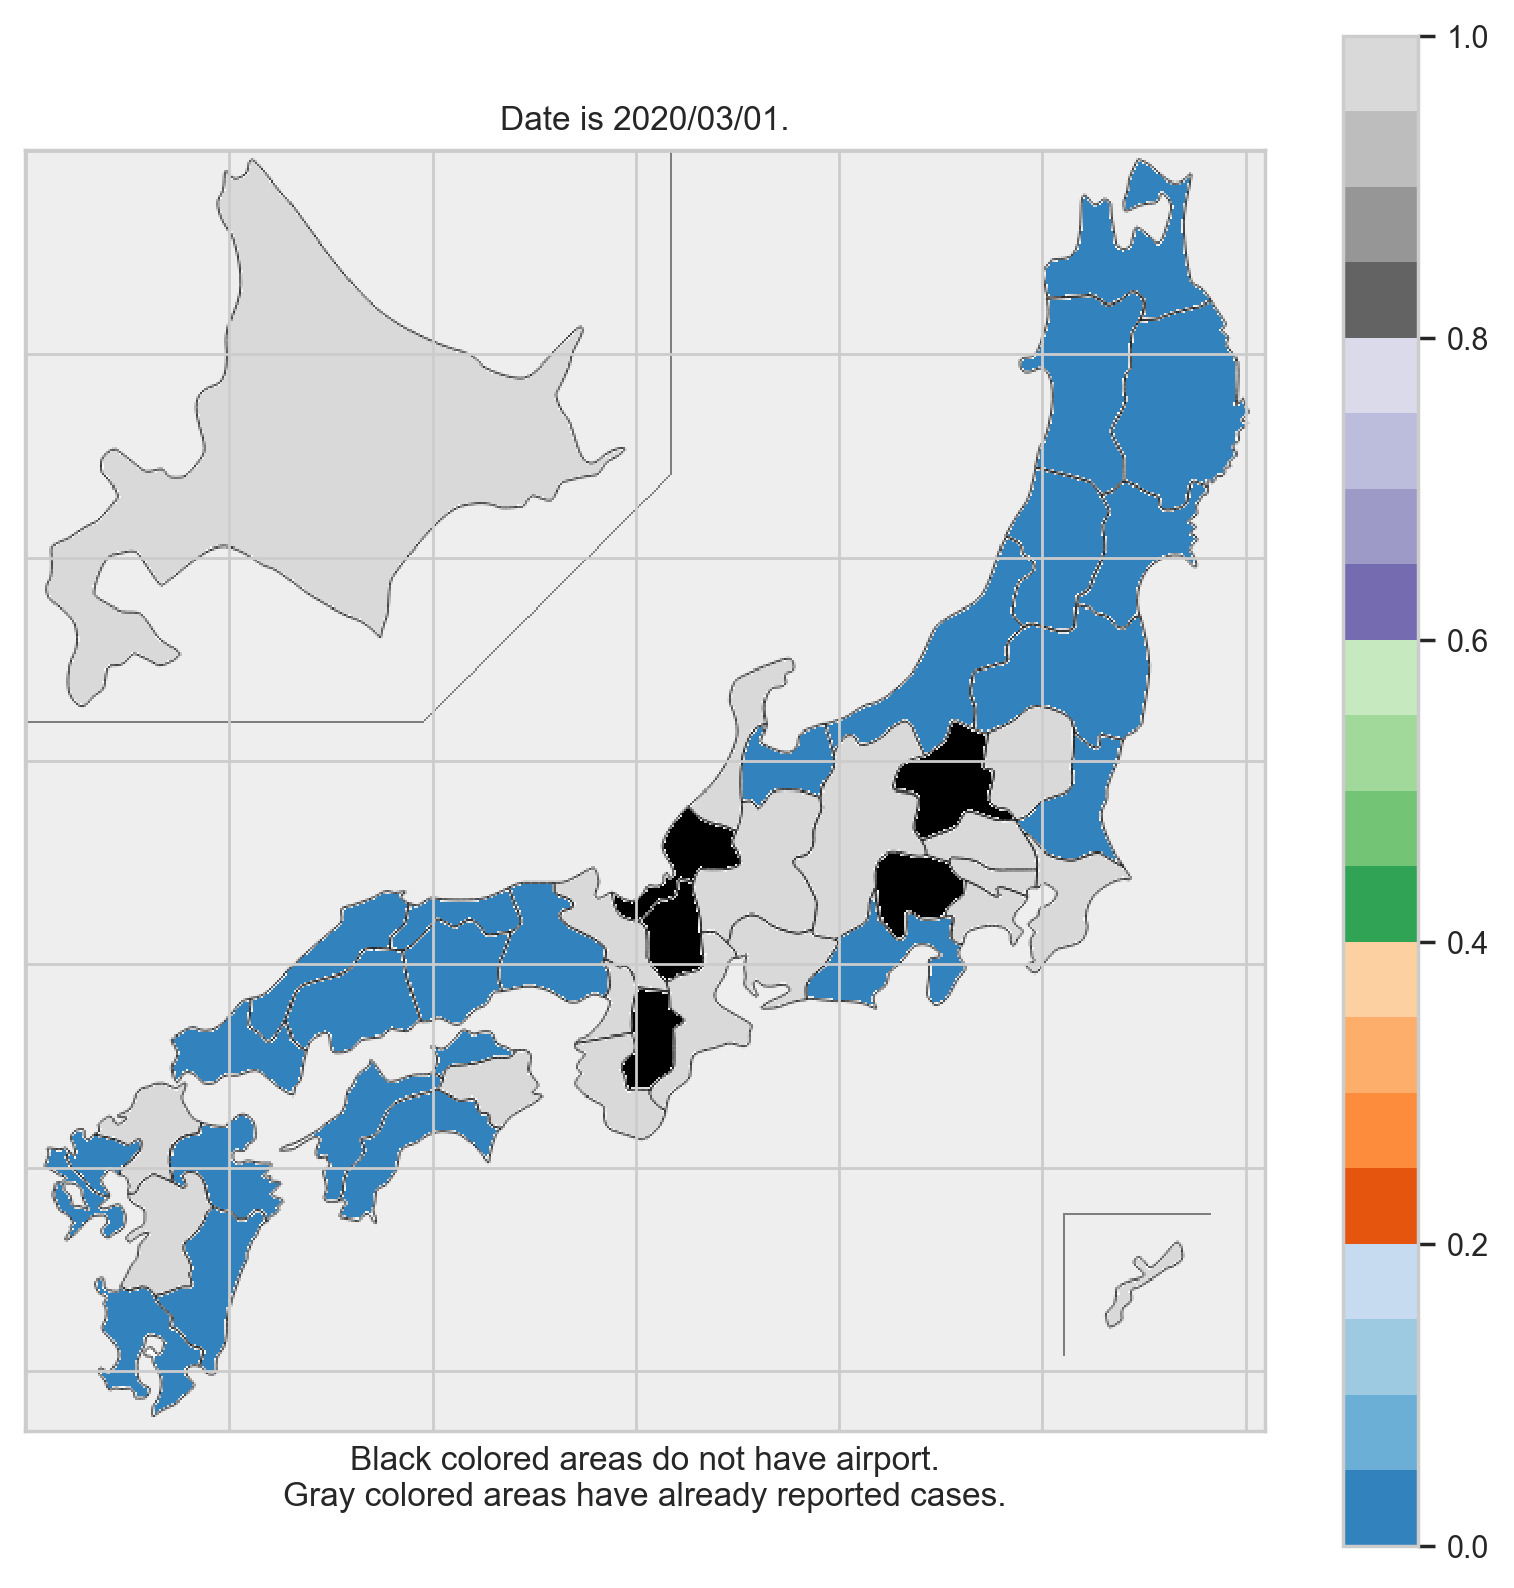

----------------------------------------------------------------------------------------------------


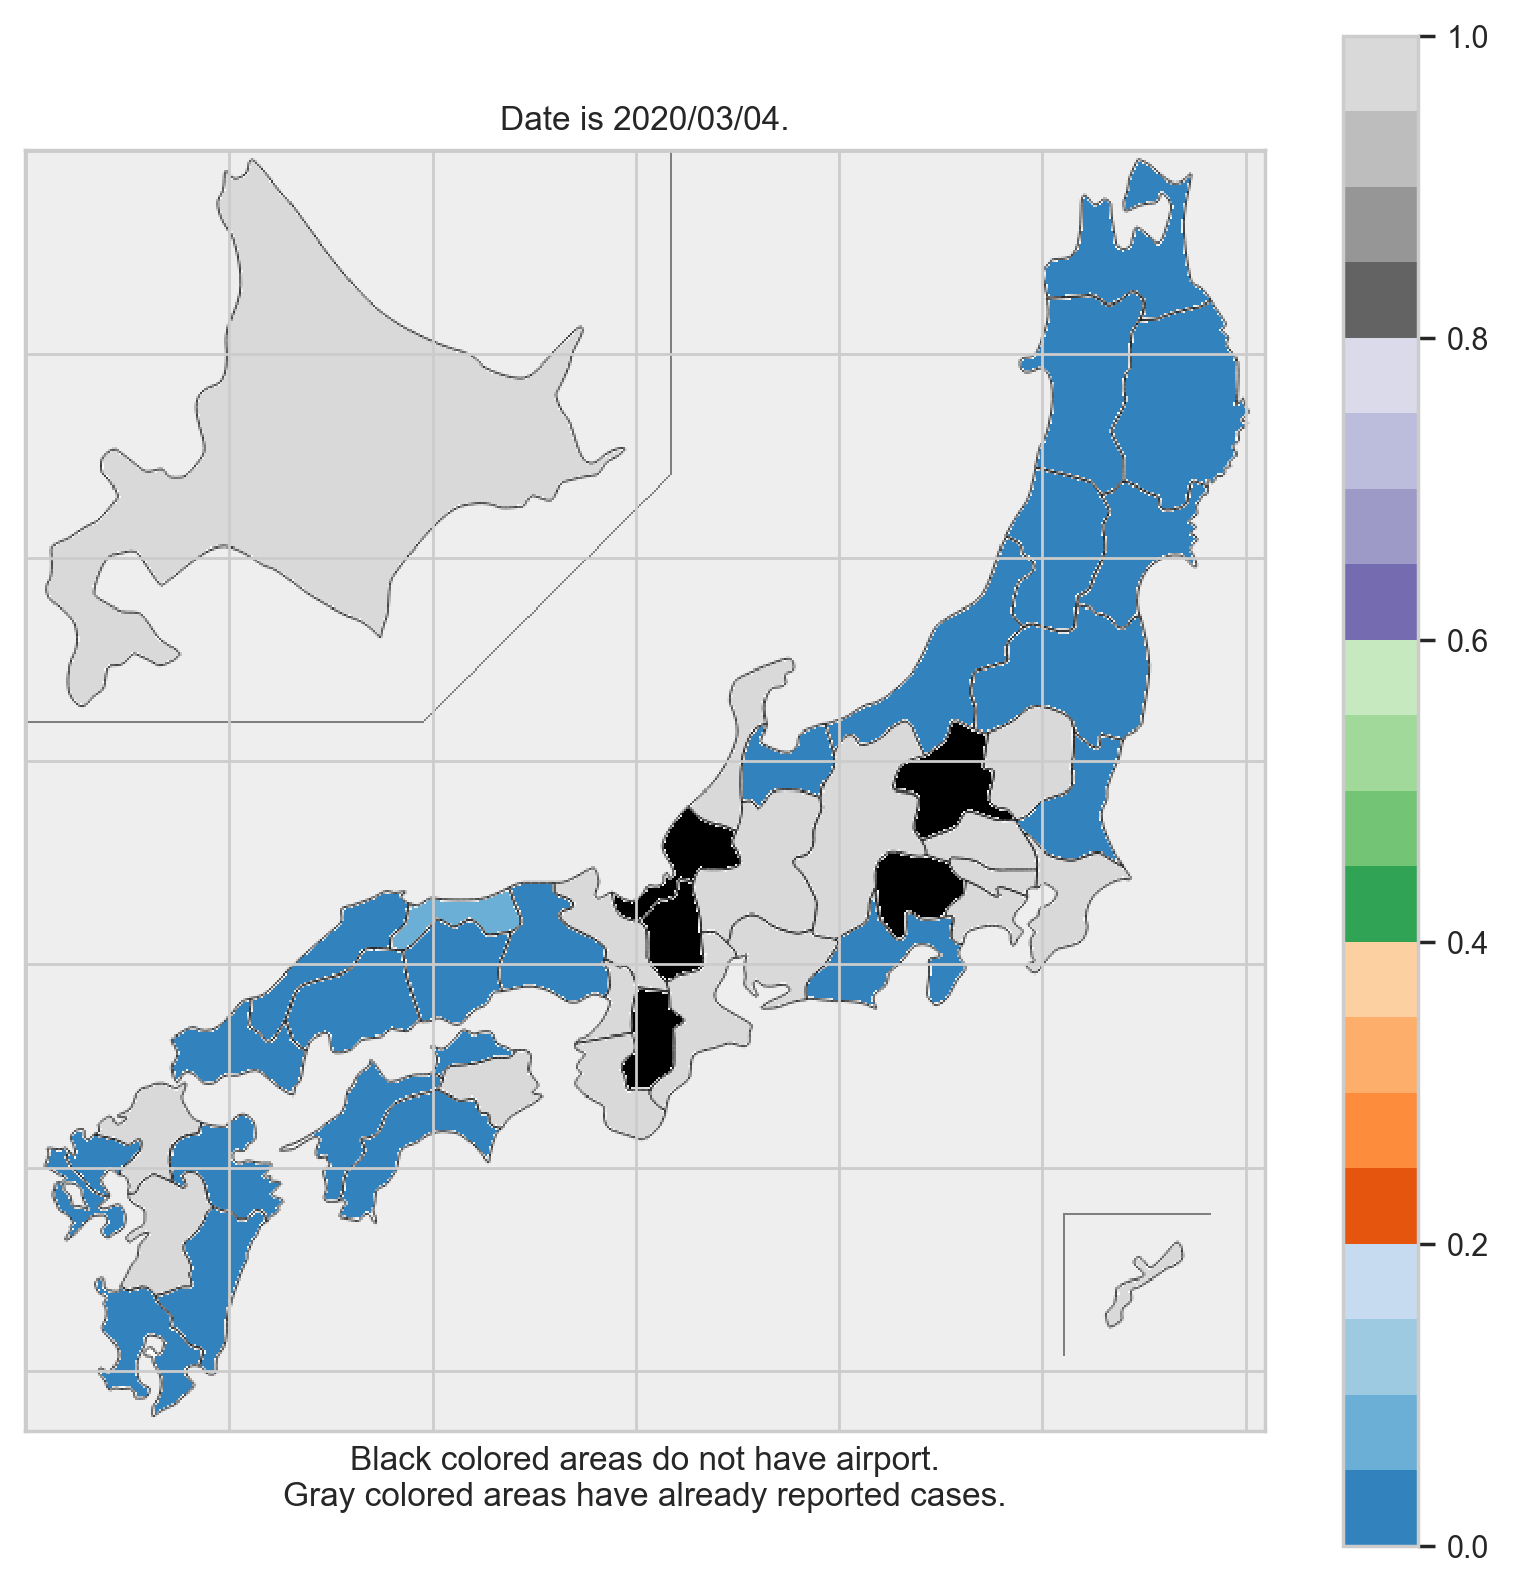

----------------------------------------------------------------------------------------------------


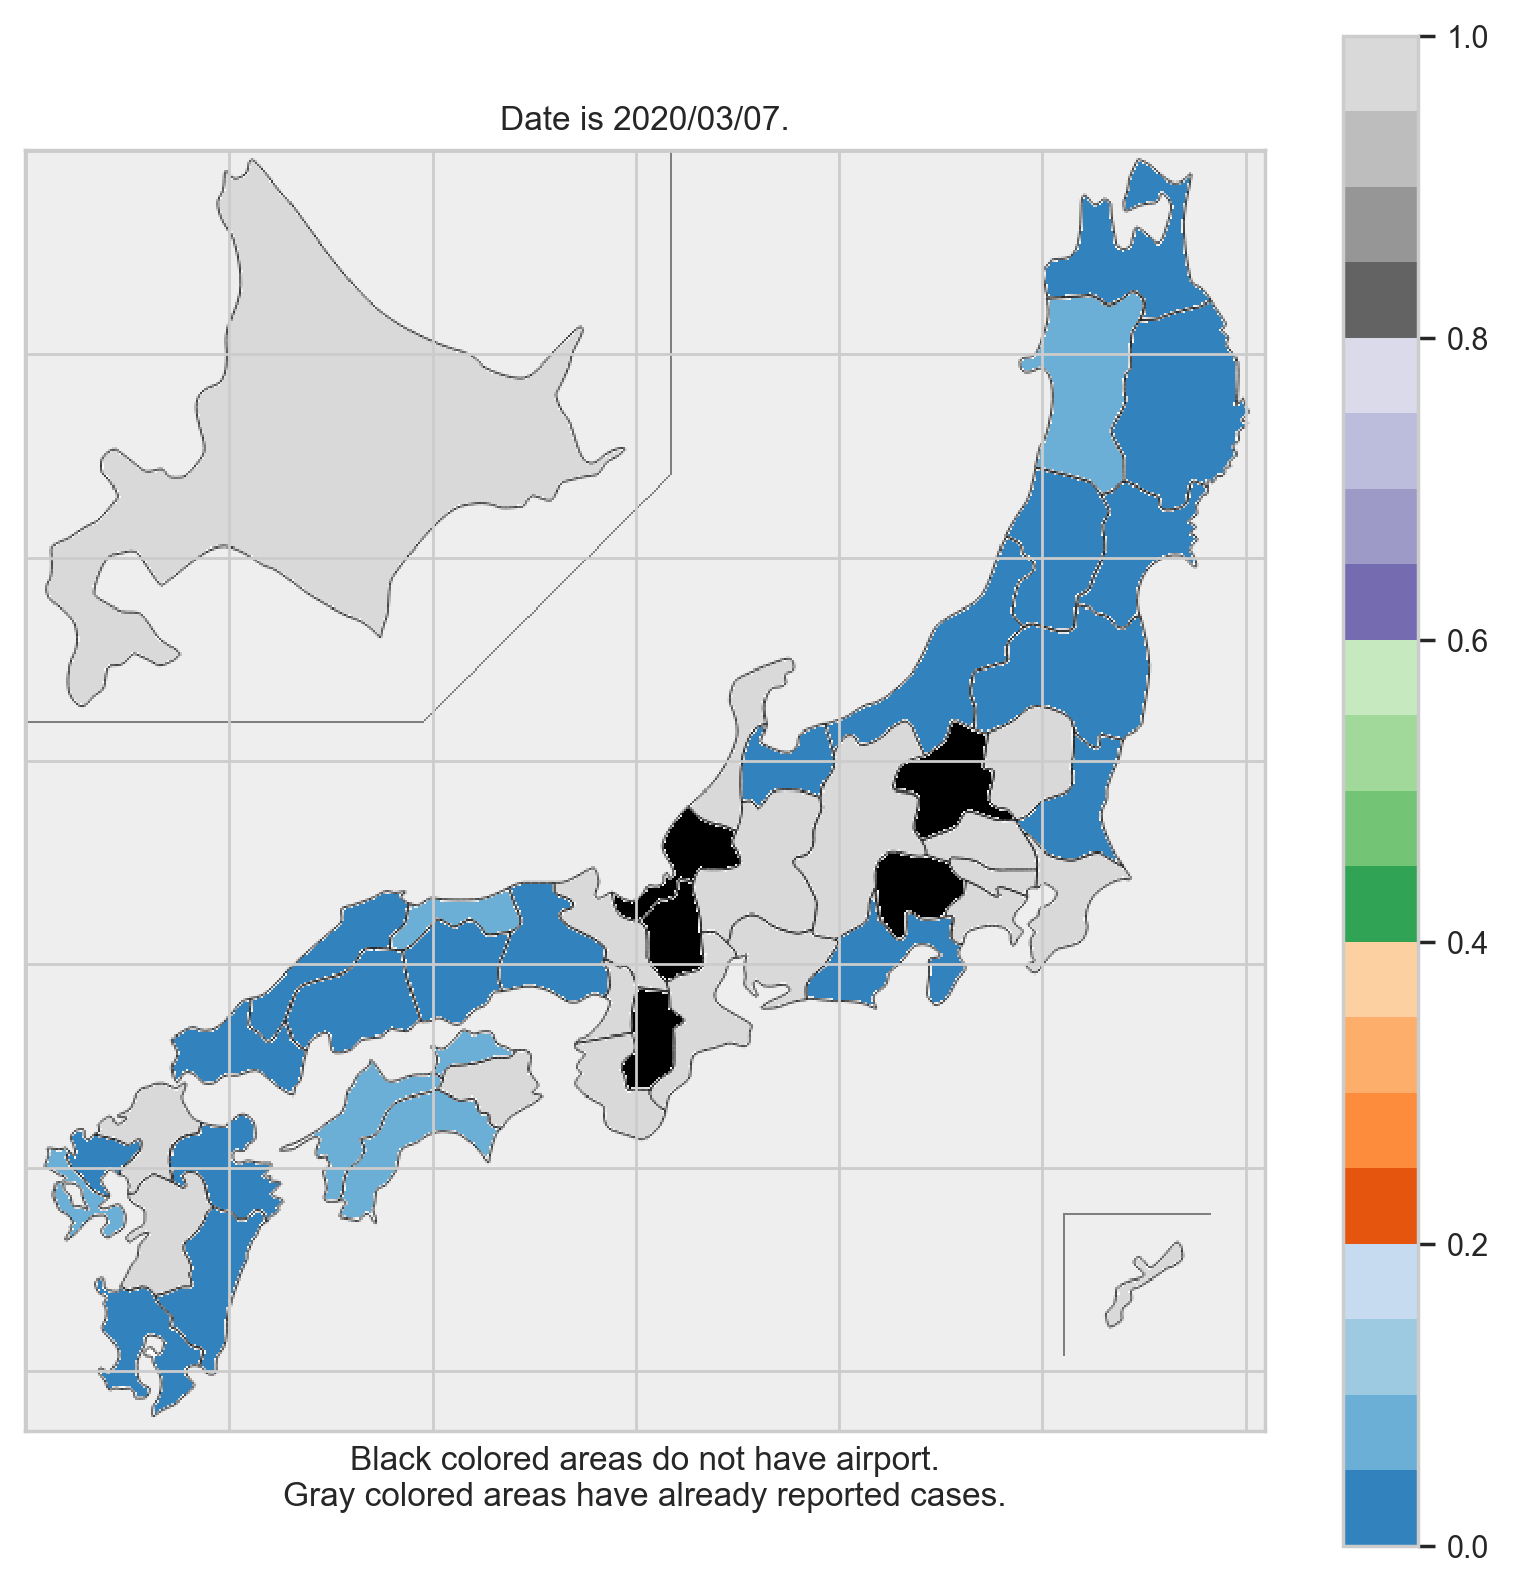

----------------------------------------------------------------------------------------------------


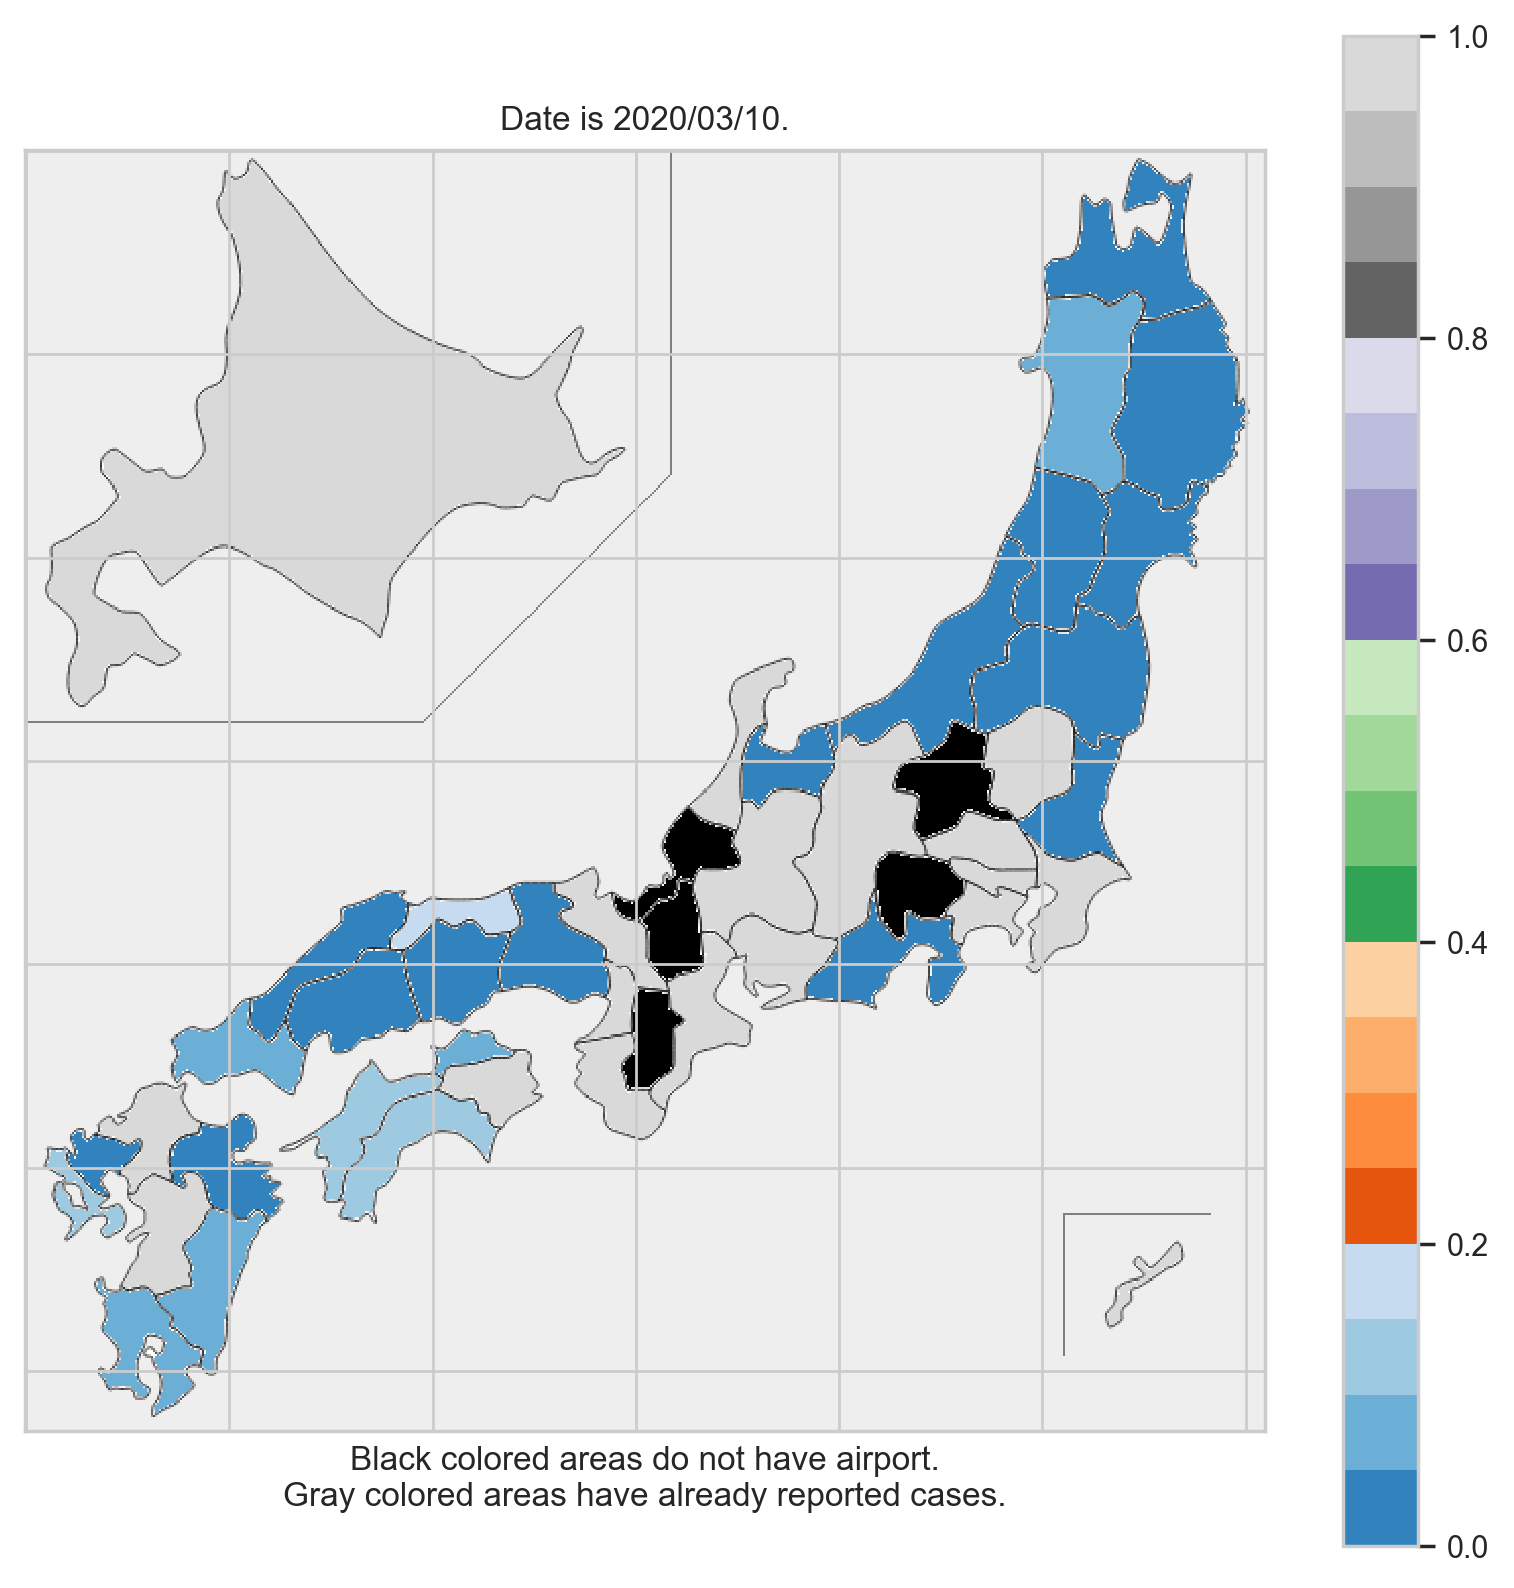

----------------------------------------------------------------------------------------------------


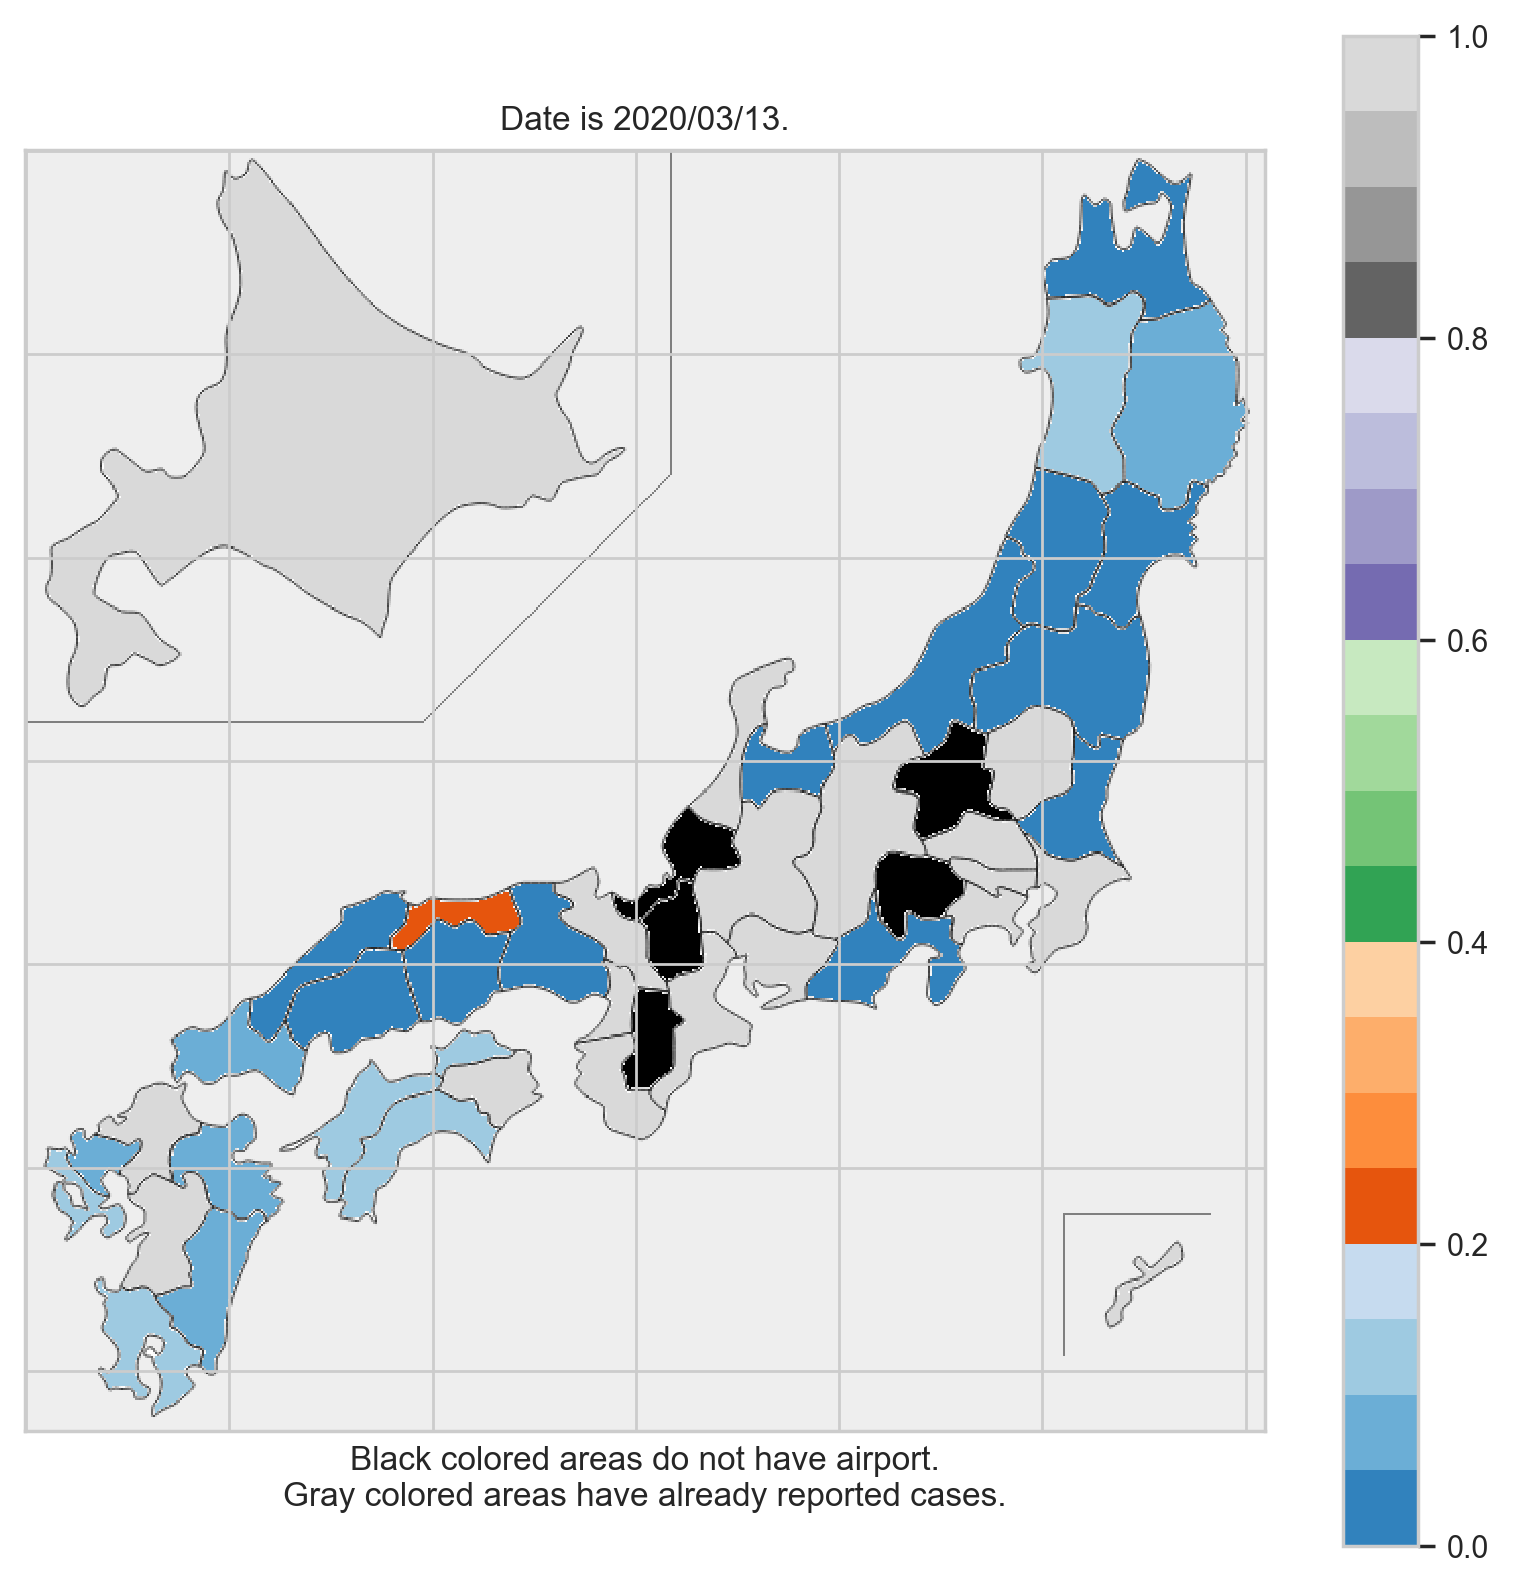

----------------------------------------------------------------------------------------------------


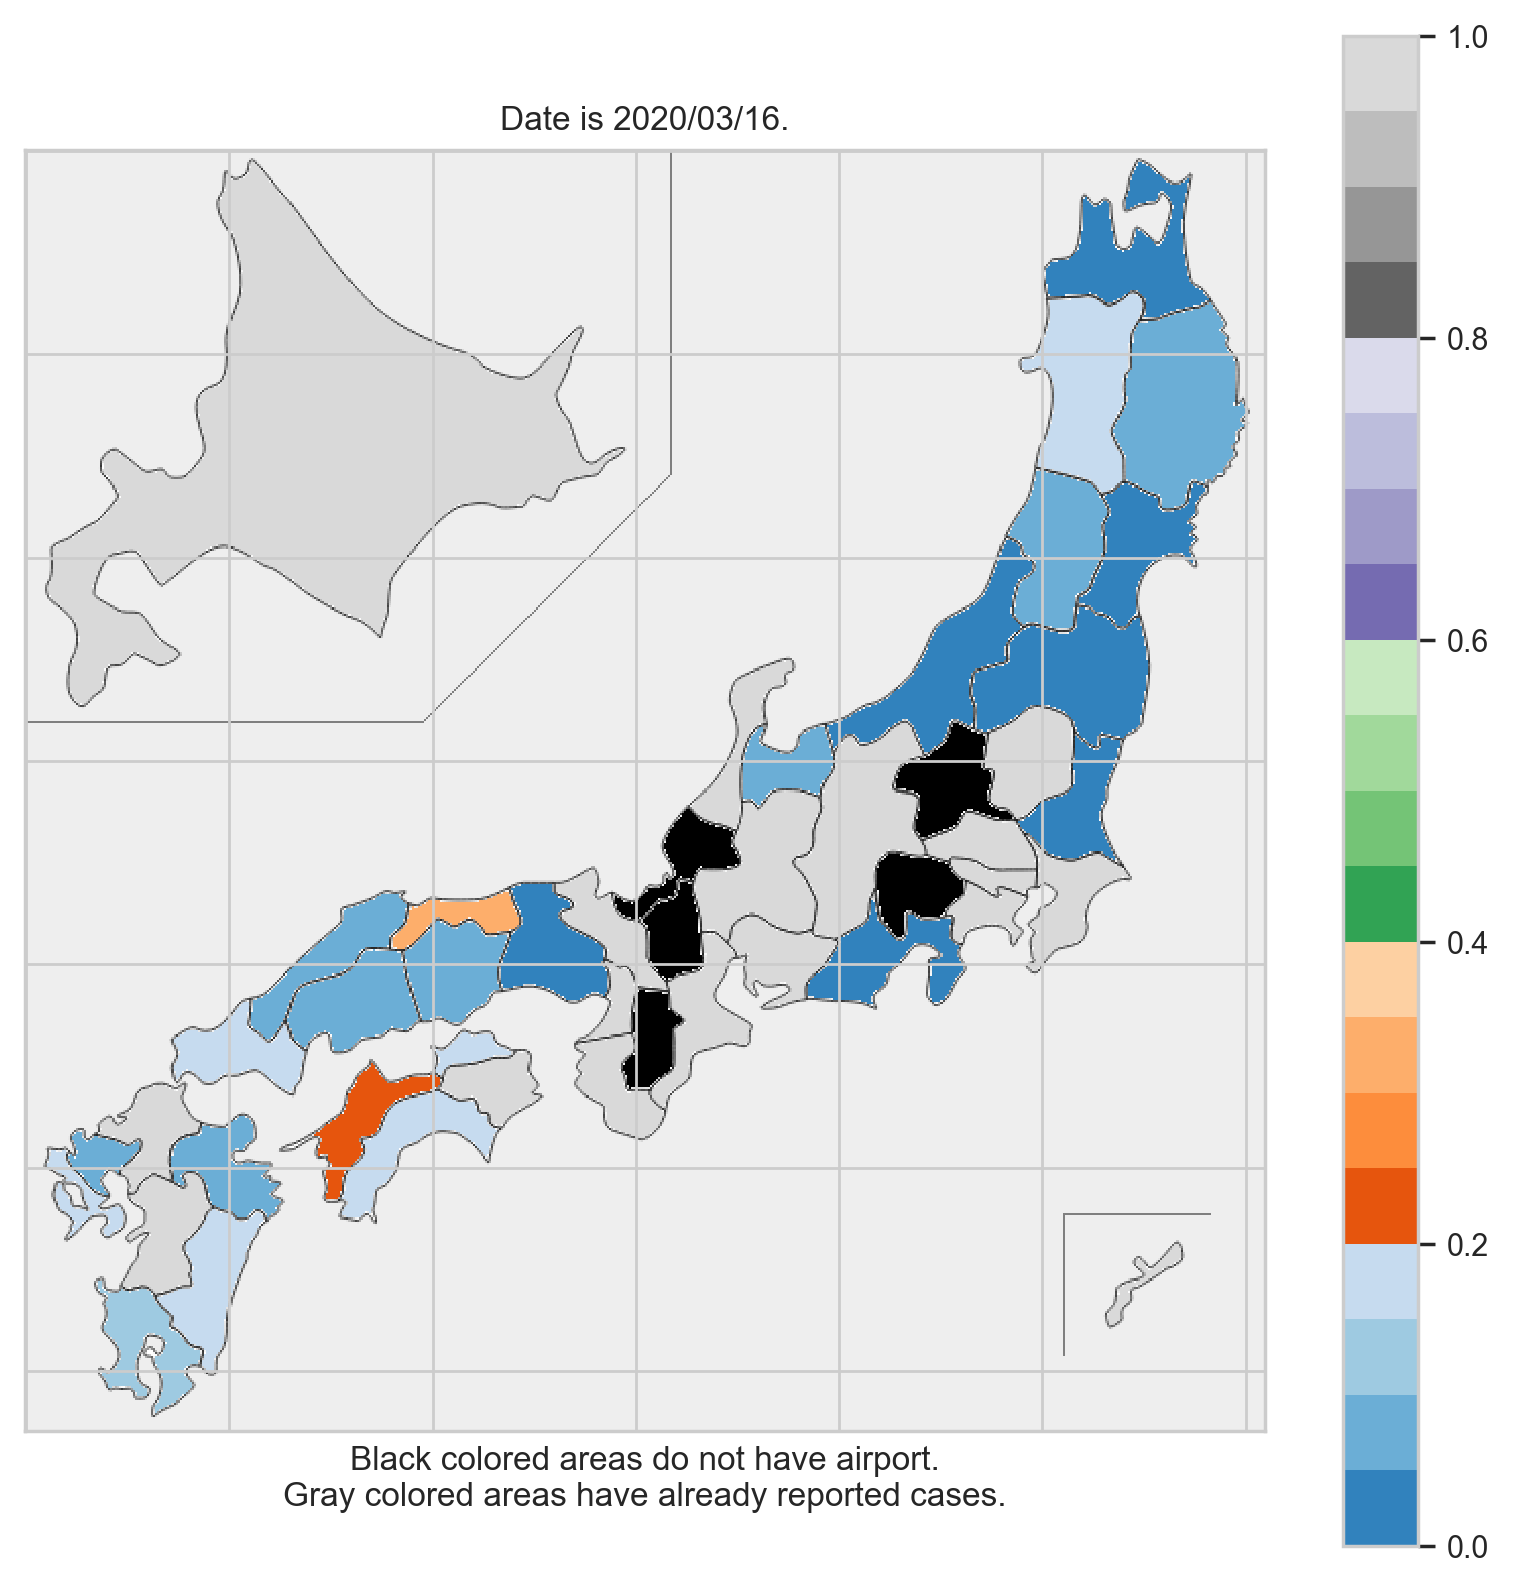

----------------------------------------------------------------------------------------------------


In [115]:
base = pL.baseDate.strftime("%Y/%m/%d")
print(f"the start date of the simulations is {base} at some date.")
tExts = [3,6,9,12,15,18]
for tExt in tExts:
    enterProb = vT.getEnterProb(tExt,d)
    vT.japanVis(enterProb,tExt,notInList = pL.notIn) 